In [1]:
import jax
print("jax version: ", jax.__version__)
import jax.numpy as np
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

rng = jax.random.PRNGKey(2)

jax version:  0.2.10


In [2]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

# for imnn
import imnn
import imnn.lfi
import jax
import jax.numpy as np
import jax_cosmo as jc
import matplotlib.pyplot as plt
import tensorflow_probability
from jax.experimental import optimizers
from jax.experimental import stax
tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tensorflow_probability.substrates.jax as tfpj
tfdj = tfpj.distributions
tfbj = tfpj.bijectors

import tensorflow.keras.backend as K

In [4]:
class ConditionalMaskedAutoregressiveFlow(tf.Module):
    def __init__(self, n_dimensions=None, n_conditionals=None, n_mades=1, n_hidden=[50,50], input_order="random",
    activation=tf.keras.layers.LeakyReLU(0.01), 
    all_layers=True,
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None), 
    bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
    kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    bias_constraint=None):
        super(ConditionalMaskedAutoregressiveFlow, self).__init__()
        # extract init parameters
        self.n_dimensions = n_dimensions
        self.n_conditionals = n_conditionals
        self.n_mades = n_mades
        # construct the base (normal) distribution
        self.base_distribution = tfd.MultivariateNormalDiag(loc=tf.zeros(self.n_dimensions), scale_diag=tf.ones(self.n_dimensions))
        # put the conditional inputs to all layers, or just the first layer?
        if all_layers == True:
            all_layers = "all_layers"
        else:
            all_layers = "first_layer"
        # construct stack of conditional MADEs
        self.MADEs = [tfb.AutoregressiveNetwork(
                        params=2,
                        hidden_units=n_hidden,
                        activation=activation,
                        event_shape=[n_dimensions],
                        conditional=True,
                        conditional_event_shape=[n_conditionals],
                        conditional_input_layers=all_layers,
                        input_order=input_order,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer,
                        kernel_regularizer=kernel_regularizer,
                        bias_regularizer=bias_regularizer,
                        kernel_constraint=kernel_constraint,
                        bias_constraint=bias_constraint,
                        name="MADE_{}".format(i)) for i in range(n_mades)]
    # bijector for x | y (chain the conditional MADEs together)
    def bijector(self, y):
        # start with an empty bijector
        MAF = tfb.Identity() 
        # pass through the MADE layers (passing conditional inputs each time)
        for i in range(self.n_mades):
            MAF = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda x: self.MADEs[i](x, conditional_input=y))(MAF)
        return MAF
    # construct distribution P(x | y)
    def __call__(self, y):
        return tfd.TransformedDistribution(
            self.base_distribution,
            bijector=self.bijector(y))
    # log probability ln P(x | y)
    def log_prob(self, x, y):
        return self.__call__(y).log_prob(x)
    # sample n samples from P(x | y)
    def sample(self, n, y):
        # base samples
        base_samples = self.base_distribution.sample(n)
        # biject the samples
        return self.bijector(y).forward(base_samples)

In [5]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss_value = K.mean(-cmaf_model.log_prob(x, y))
        
    grads = tape.gradient(loss_value, cmaf_model.trainable_variables)
    maf_optimizer.apply_gradients(zip(grads, cmaf_model.trainable_variables))
    #train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def loss(x, y):
    return K.mean(-cmaf_model.log_prob(x, y))

In [278]:
#@tf.function
def val_step(x, y):
    val_loss = K.mean(-cmaf_model.log_prob(x, y))
    return val_loss

# get dataset

In [96]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output
import jax.numpy as np

scaler = preprocessing.StandardScaler()

%matplotlib inline

In [156]:
def my_make_moons(rng, n_samples=100, noise=0.05):


    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - .5

    X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                   np.append(outer_circ_y, inner_circ_y)]).T


    X += jax.random.normal(rng, shape=X.shape) * noise

    return X


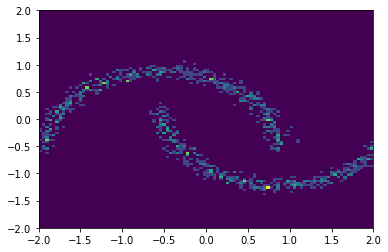

In [229]:
n_samples = 1000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

simulator_args = {'n': 1}

# for the moons dataset, our params are just the noise width

def simulator(rng, ϑ, n_samples=1000):
    σ = ϑ
    if n_samples is None:
        n_samples = simulator_args['n']
    
    _X = my_make_moons(rng, n_samples=n_samples, noise=σ)
    
    
    
    return ((_X - np.mean(_X)) / np.std(_X)).flatten()


rng,key = jax.random.split(rng)
ϑ_fid = 0.05
X = simulator(key, ϑ_fid, n_samples=1000).reshape(n_samples, 2)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1]

In [230]:
# build IMNN network
n_params = 1
n_summaries = 1
θ_fid = np.array([0.1], dtype='float32')

def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun

input_shape = (2000,)

network = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries)
)

In [231]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

optimiser = optimizers.adam(step_size=1e-3)

In [232]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=2000,
        n_d=2000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=network,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: simulator(
            rng, θ),
        )

`simulator` provided, using SimulatorIMNN


In [233]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=True)

CPU times: user 6.76 s, sys: 111 ms, total: 6.87 s
Wall time: 5.16 s


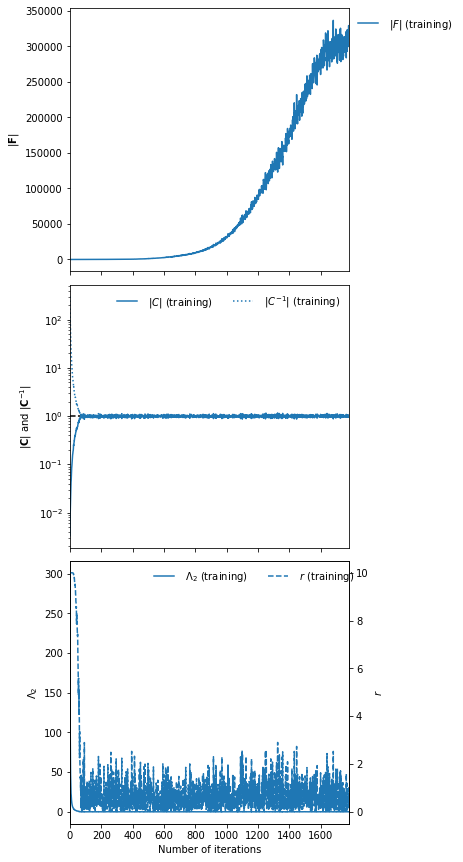

In [234]:
ax = IMNN.plot(expected_detF=None)

In [253]:
_n = 34
keys = jax.random.split(rng, num=_n)
ϑ_samp = prior.sample(sample_shape=(_n,), seed=key)
keys = np.array(jax.random.split(key, num=_n))
d = jax.vmap(simulator)(keys, ϑ_samp)

In [254]:
d.shape

(34, 2000)

In [255]:
# create dataset for this demo


prior = tfpj.distributions.Blockwise(
    [tfpj.distributions.Uniform(low=low, high=high)
     for low, high in zip([0.01], [0.5])])

prior.low = np.array([0.01])
prior.high = np.array([0.5])

num_sims = 1000
ϑ_samp = prior.sample(sample_shape=(num_sims,), seed=rng)

keys = jax.random.split(rng, num=num_sims)


def get_params_summaries(key, n_samples, dist):
    ϑ_samp = dist.sample(sample_shape=(n_samples,), seed=key)
    keys = np.array(jax.random.split(key, num=n_samples))
    d = jax.vmap(simulator)(keys, ϑ_samp)
    
    t = IMNN.get_estimate(d)
    
    t1 = t[~np.isnan(t)]
    #print(np.isnan(t).T[0].shape)
    #ϑ_samp = ϑ_samp[~np.isnan(t).T[0].T]
    
    return ϑ_samp, t


def get_dataset(data, batch_size=20, split=0.75):
    x,y = data
    
    idx = int(len(x)*split)
    x_train = x[:idx]
    y_train = y[:idx]  
    x_val = x[idx:]
    y_val = y[idx:]

    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

def proposal_distribution(prior, MAF):
    """return geometric mean of proposal distribution"""
    pass
    
    

In [256]:
prior.sample(seed=rng)

DeviceArray([0.38570794], dtype=float32)

In [257]:
rng,key = jax.random.split(rng)
ϑ_samp = prior.sample((100,), key)
blah =  cmaf_model.sample((100,), ϑ_samp)

In [258]:
data = get_params_summaries(key, 1000, dist=prior)

In [260]:
data[0].shape

(1000, 1)

In [267]:
train_dataset, val_dataset = get_dataset(data, batch_size=100)

In [275]:
cmaf_model = ConditionalMaskedAutoregressiveFlow(n_dimensions=1, n_conditionals=1)
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [279]:
import time
from tqdm import tqdm

epochs = 2000

train_losses = []
val_losses = []


for epoch in tqdm(range(epochs)):
    #print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()


    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        #print(loss_value)
        # Log every 200 batches.
       # if step % 200 == 0:
           # print(
          #      "Training loss (for one batch) at step %d: %.4f"
          #      % (step, float(loss_value))
          #  )
            #print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    #train_acc = train_acc_metric.result()
    train_losses.append(loss_value)
    #print("Training loss over epoch: %.4f" % (float(loss_value),))

    # Reset training metrics at the end of each epoch
    #train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_loss = val_step(x_batch_val, y_batch_val)

    val_losses.append(val_loss)
    #val_acc = val_acc_metric.result()
    #val_acc_metric.reset_states()
    #print("Validation loss: %.4f" % (float(val_loss),))
    #print("Time taken: %.2fs" % (time.time() - start_time))

 70%|██████▉   | 1396/2000 [09:27<04:05,  2.46it/s]


KeyboardInterrupt: 

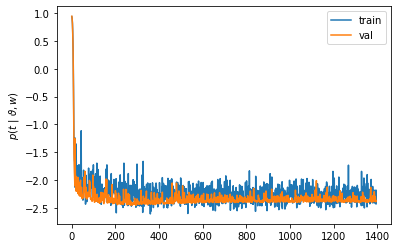

In [288]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.ylabel(r'$p(t\ |\ \vartheta, w)$')
plt.legend()

In [281]:
# num_points = 1000
# x1 = np.linspace(prior.low[1], prior.high[1], num=num_points)
# x2 = np.linspace(prior.low[0], prior.high[1], num=num_points)
# prior.prob(np.stack([x1, x2], axis=-1));

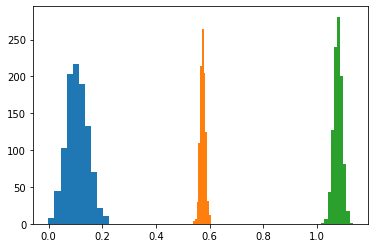

In [337]:
# generate a bunch of targets:

θ_targets = np.array([0.02, 0.55, 1.0])

for t in θ_targets:


    target_data = simulator(rng, t)

    estimates = IMNN.get_estimate(target_data)

    post = cmaf_model.sample((num_points,), estimates)
    
    plt.hist(np.squeeze(np.array(post)))


In [329]:
p_prior = np.abs(prior.low - prior.high)

(array([  4.,  22.,  78., 140., 211., 229., 173.,  96.,  33.,  14.]),
 array([0.00844962, 0.03096722, 0.05348482, 0.07600241, 0.09852001,
        0.1210376 , 0.14355521, 0.1660728 , 0.18859039, 0.211108  ,
        0.23362559], dtype=float32),
 <BarContainer object of 10 artists>)

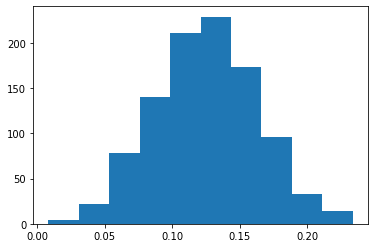

In [331]:
plt.hist(np.squeeze(np.array(post)))